<a href="https://colab.research.google.com/github/masalha-alaa/mnist-pytorch/blob/master/MNIST_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data_utils

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np

In [78]:
# Use GPU if available

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {device}')

Running on cuda


# Load the dataset

In [79]:
batch_size = 64

# training + validation dataset
training_set_full = datasets.MNIST('dataset/', train=True, transform=transforms.ToTensor(), download=True)

# test dataset
test_set = datasets.MNIST('dataset/', train=False, transform=transforms.ToTensor(), download=True)

##Peek at the data

In [80]:
SAMPLE_IMG_ID = 0

print(f'Training data: {len(training_set_full)}, Sample structure: ({type(training_set_full[SAMPLE_IMG_ID][0])} {training_set_full[SAMPLE_IMG_ID][0].shape}, {type(training_set_full[SAMPLE_IMG_ID][1])})')
print(f'Test data: {len(test_set)}, Sample structure: ({type(test_set[SAMPLE_IMG_ID][0])} {test_set[SAMPLE_IMG_ID][0].shape}, {type(test_set[SAMPLE_IMG_ID][1])})')

Training data: 60000, Sample structure: (<class 'torch.Tensor'> torch.Size([1, 28, 28]), <class 'int'>)
Test data: 10000, Sample structure: (<class 'torch.Tensor'> torch.Size([1, 28, 28]), <class 'int'>)


In [81]:
IMAGE_SHAPE = training_set_full[0][0].shape[1], training_set_full[0][0].shape[2]
classes = np.unique([t[1] for t in training_set_full])
NUM_CLASSES = len(classes)

In [82]:
print(f'Classes: {classes}')

Classes: [0 1 2 3 4 5 6 7 8 9]


## Split to train / validation / test

In [83]:
VALIDATION_FRAC = 0.1

np.random.seed(42)
shuffled_idx = np.random.choice(len(training_set_full), len(training_set_full), replace=False)
validation_set = data_utils.Subset(training_set_full, shuffled_idx[:int(len(training_set_full) * 0.1)])
training_set = data_utils.Subset(training_set_full, shuffled_idx[int(len(training_set_full) * 0.1):])

print('Data size after splitting to train / validation / test:')
print(f'Training data: {len(training_set)}, Sample structure: ({type(training_set[SAMPLE_IMG_ID][0])} {training_set[SAMPLE_IMG_ID][0].shape}, {type(training_set[SAMPLE_IMG_ID][1])})')
print(f'Validation data: {len(validation_set)}, Sample structure: ({type(validation_set[SAMPLE_IMG_ID][0])} {validation_set[SAMPLE_IMG_ID][0].shape}, {type(validation_set[SAMPLE_IMG_ID][1])})')
print(f'Test data: {len(test_set)}, Sample structure: ({type(test_set[SAMPLE_IMG_ID][0])} {test_set[SAMPLE_IMG_ID][0].shape}, {type(test_set[SAMPLE_IMG_ID][1])})')

training_loader = DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)

Data size after splitting to train / validation / test:
Training data: 54000, Sample structure: (<class 'torch.Tensor'> torch.Size([1, 28, 28]), <class 'int'>)
Validation data: 6000, Sample structure: (<class 'torch.Tensor'> torch.Size([1, 28, 28]), <class 'int'>)
Test data: 10000, Sample structure: (<class 'torch.Tensor'> torch.Size([1, 28, 28]), <class 'int'>)


##Visualize the data

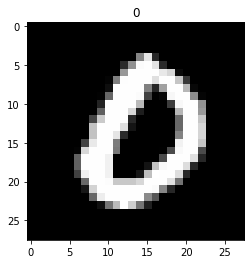

In [84]:
SAMPLE_IMG_ID = np.random.choice(len(training_set))

junk = plt.imshow(training_set[SAMPLE_IMG_ID][0].squeeze(0), cmap='gray')  # "squeeze" removes the first dimension (1,28,28) => (28,28)
junk = plt.title(training_set[SAMPLE_IMG_ID][1])

# Model

In [85]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, classes):
        super().__init__()
        # layer 1
        self.fc1 = nn.Linear(input_size, 50)
        # layer 2
        self.fc2 = nn.Linear(50, classes)

    def forward(self, x):
        # run x through the layers and activation functions
        # (relu activation function is just max(0, x))
        x = F.relu(self.fc1(x))
        # normally there's no activation function on last layer (except softmax etc. when needed)
        x = self.fc2(x)

        return x

model = SimpleNeuralNetwork(np.product(IMAGE_SHAPE), NUM_CLASSES)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [86]:
def evaluate(model, loss_function, X, y):
    # flatten the data from (batch_size, W, H) to (batch_size, W*H) because pytorch models require 1 dimensional samples, and run model.
    predictions = model(X.reshape(X.shape[0], -1))  # Module class implements the __call__ method. that's why this class instance is callable although it's not a function.
                                                    # its __call__ method simply calls our forward() method.
    
    loss = loss_function(predictions, y)
    predictions = predictions.argmax(dim=1).cpu().numpy()
    acc = (predictions == y.cpu().numpy()).mean()
    return predictions, acc, loss

## Training

In [87]:
EPOCHS = 7
EVALUATION_FREQ = len(training_set) // batch_size // 10  # guarantee 10 evaluations per epoch

model.train(mode=True)  # just puts the model in training mode (doesn't actually train)

training_acc_lst, training_loss_lst = [], []
validation_acc_lst, validation_loss_lst = [], []
epochs_acc = []
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}')
    epoch_acc = []
    training_acc_checkpoint, training_loss_checkpoint = [], []
    for batch_idx, (data, labels) in enumerate(training_loader):
        # cast to device (cpu / gpu) (gpu for faster op). also both need to be on same device.
        data, labels = data.to(device), labels.to(device)
        
        # run model on data to get predictions.
        # as we saw earlier, training_set[i][0] is of shape (1,28,28),
        # that means data is of shape (batch_size, 1, 28, 28),
        # but pytorch models require each sample to be 1 dimensional, so we need to flatten the data to (batch_size, 28*28) (done in evaluate())
        predictions, acc, loss = evaluate(model, loss_function, data, labels)
        training_acc_checkpoint.append(acc)
        epoch_acc.append(acc)

        # loss already calculated in the evaluate() call. just append it
        training_loss_checkpoint.append(loss.item())
        
        # back propagation (calculate the gradient)
        loss.backward()

        # gradient descent (adjust the weights)
        optimizer.step()

        # default behavior of pytorch is to NOT clear the gradients after every step.
        # but we need to clear them to prevent accumulation of gradients throughout iterations.
        optimizer.zero_grad()  # or model.zero_grad() if all the model's parameters are in the optimizer (in our case they are)

        # evaluate on validation
        if batch_idx % EVALUATION_FREQ == 0:
            # average training acc and loss every EVALUATION_FREQ, so our training and validation plots axes will have the same length
            training_acc_lst.append(np.mean(training_acc_checkpoint))
            training_loss_lst.append(np.mean(training_loss_checkpoint))
            # restart checkpoints
            training_acc_checkpoint, training_loss_checkpoint = [], []

            # predict validation data, but first disable gradient tracking, and enter evaluation mode
            model.train(mode=False)  # enter eval mode. suggested here: https://stackoverflow.com/a/55627781/900394
            with torch.no_grad():  # locally disable gradient tracking
                validation_acc_checkpoint, validation_loss_checkpoint = [], []
                validation_predictions = []  # saved for showing results later
                for val_batch_idx, (val_data, val_labels) in enumerate(validation_loader):
                    val_data, val_labels = val_data.to(device), val_labels.to(device)

                    val_predictions, validation_acc, validation_loss = evaluate(model, loss_function, val_data, val_labels)
                    
                    validation_loss_checkpoint.append(validation_loss.item())
                    validation_acc_checkpoint.append(validation_acc)
                    validation_predictions.extend(val_predictions)  # predictions are for a complete batch, so we need to "extend" not "append"
                
                validation_acc_lst.append(np.mean(validation_acc_checkpoint))
                validation_loss_lst.append(np.mean(validation_loss_checkpoint))
            
            print(f'Training acc: {training_acc_lst[-1]:.2f}, Training loss: {training_loss_lst[-1]:.2f}, Validation acc: {validation_acc_lst[-1]:.2f}, Validation loss: {validation_loss_lst[-1]:.2f}')

            model.train(mode=True)  # re-enter training mode

    # epoch end
    epochs_acc.append(np.mean(epoch_acc))
    # early stopping according to accuracy
    # TODO: allow K consecutive and / or take validation acc into account
    if len(epochs_acc) > 1 and epochs_acc[-1] - epochs_acc[-2] < 0.01:
        print(f'{epochs_acc[-1] - epochs_acc[-2]:.2f} accuracy change. Early stopping...')
        break

junk = model.train(mode=False)  # exit training mode

Epoch 1
Training acc: 0.05, Training loss: 2.32, Validation acc: 0.13, Validation loss: 2.28
Training acc: 0.70, Training loss: 1.23, Validation acc: 0.85, Validation loss: 0.64
Training acc: 0.88, Training loss: 0.50, Validation acc: 0.88, Validation loss: 0.43
Training acc: 0.89, Training loss: 0.40, Validation acc: 0.90, Validation loss: 0.36
Training acc: 0.90, Training loss: 0.37, Validation acc: 0.91, Validation loss: 0.33
Training acc: 0.90, Training loss: 0.35, Validation acc: 0.91, Validation loss: 0.32
Training acc: 0.91, Training loss: 0.32, Validation acc: 0.91, Validation loss: 0.30
Training acc: 0.91, Training loss: 0.31, Validation acc: 0.92, Validation loss: 0.29
Training acc: 0.92, Training loss: 0.28, Validation acc: 0.92, Validation loss: 0.28
Training acc: 0.92, Training loss: 0.27, Validation acc: 0.93, Validation loss: 0.26
Training acc: 0.93, Training loss: 0.26, Validation acc: 0.93, Validation loss: 0.25
Epoch 2
Training acc: 0.94, Training loss: 0.25, Validati

# Plot results

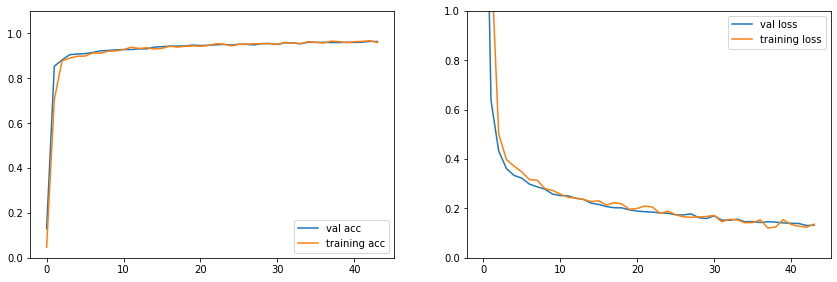

In [88]:
plot_checkpoints = (0, None)  # None to plot to the end
plt.figure(figsize=(30, 10))
        
# accuracy
plt.subplot(2,4,1)
plt.ylim(0,1.1)
plt.plot(range(len(validation_acc_lst[plot_checkpoints[0]:plot_checkpoints[1]])), validation_acc_lst[plot_checkpoints[0]:plot_checkpoints[1]])
plt.plot(range(len(training_acc_lst[plot_checkpoints[0]:plot_checkpoints[1]])), training_acc_lst[plot_checkpoints[0]:plot_checkpoints[1]])
plt.legend(['val acc', 'training acc'])

# loss
plt.subplot(2,4,2)
plt.ylim(0,1)
plt.plot(range(len(validation_loss_lst[plot_checkpoints[0]:plot_checkpoints[1]])), validation_loss_lst[plot_checkpoints[0]:plot_checkpoints[1]])
plt.plot(range(len(training_loss_lst[plot_checkpoints[0]:plot_checkpoints[1]])), training_loss_lst[plot_checkpoints[0]:plot_checkpoints[1]])
plt.legend(['val loss', 'training loss'])

plt.show()

# Visualize validation results

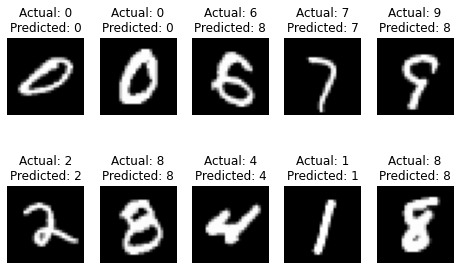

In [89]:
DRAW_IMGS = 10

# visualize validation results
fig = plt.figure(figsize=(8, 5))
fig.tight_layout()
show_imgs_idx = np.random.choice(len(validation_set), DRAW_IMGS, replace=False)
for i, (val_test_sample, val_test_label) in enumerate(data_utils.Subset(validation_set, show_imgs_idx)):
    plt.subplot(2, DRAW_IMGS // 2, i+1)
    plt.title(f'Actual: {val_test_label}\nPredicted: {validation_predictions[show_imgs_idx[i]]}')
    plt.axis('off')
    validation_img = val_test_sample.cpu().numpy()
    plt.imshow(validation_img.squeeze(0), cmap='gray')  # "squeeze" removes the first dimension (1,28,28) => (28,28)

# Testing

In [90]:
model.train(False)  # ensure we're in eval mode

test_loss = []
test_acc = []
for X,y in test_loader:
    with torch.no_grad():
        X, y = X.to(device), y.to(device)
        predictions = model(X.reshape(X.shape[0], -1))

        loss = loss_function(predictions, y)
        test_loss.append(loss.item())

        test_acc.append((predictions.argmax(dim=1).cpu().numpy() == y.cpu().numpy()).mean())

print(f'Accuracy: {np.mean(test_acc):.2f}, Loss: {np.mean(test_loss):.2f}')

Accuracy: 0.96, Loss: 0.13
